In [136]:
import os
import sys

import numpy as np
import torch as th
import pandas as pd

from stable_baselines3.common import env_checker
from stable_baselines3 import DQN, HerReplayBuffer
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env.dummy_vec_env import DummyVecEnv
from stable_baselines3.her.goal_selection_strategy import GoalSelectionStrategy

sys.path.append('../src')

from config.config import PATHS
from parser.clases_parser import ParserFOL_1f
from parser.parser_auxiliary_classes import Nodo, DictObservationWrapper
from utils.inspect import quick_inspection, q_values_at_state, rewards_at_state

from matplotlib import pyplot as plt
%matplotlib inline

1. Entrenamiento con NUM_FRASE = 8: "trees are plants":
    * env.max_turns = 1
    * model.gamma = 0
    * TIME_STEPS = 5_000
    * env.max_turns = 2
    * model.gamma = 0
    * TIME_STEPS = 5_000
    * env.max_turns = 5
    * model.gamma = 0.1
    * TIME_STEPS = 150_000

2. Entrenamiento con NUM_FRASE = 7: "all tables are round":
    * añadir la frase 7 al entorno (2 frases)
    * model.gamma = 0.1
    * env.max_turns = 1
    * TIME_STEPS = 5_000
    * env.max_turns = 2
    * TIME_STEPS = 5_000
    * env.max_turns = 3
    * TIME_STEPS = 5_000
    * env.max_turns = 5
    * TIME_STEPS = 150_000
    * env.max_turns = 7
    * TIME_STEPS = 300_000

3. Entrenamiento con NUM_FRASE = 3: "some cats are not pets":
    * añadir la frase 3 al entorno (3 frases)
    * model.gamma = 0.1
    * env.max_turns = 1
    * TIME_STEPS = 5_000
    * env.max_turns = 2
    * TIME_STEPS = 5_000
    * env.max_turns = 3
    * TIME_STEPS = 5_000
    * env.max_turns = 5
    * TIME_STEPS = 150_000
    * env.max_turns = 7
    * TIME_STEPS = 300_000

In [137]:
NUM_FRASES = [8]  #, 7]
MAX_TURNS = 1

## Carga y estandarizacion de FOLIO - Smallest

El conjunto de datos cargado es un subconjunto del dataset FOLIO. Este contiene los 10 ejemplos de longitud mas corta con el fin de probar el desempenio del agente en el entorno

In [138]:
df = pd.read_csv(PATHS['fol_data_folder']/'smallest_ordered.csv')
df.drop(columns=['Unnamed: 0', 'length'], inplace=True)
# df = pd.DataFrame(df.loc[NUM_FRASE].to_frame().T)
df = df.iloc[NUM_FRASES]
df.reset_index(drop=True, inplace=True)
df

,frase,frase-FOL,pregunta,respuesta,tipo_pregunta
0,Trees are plants.\r\nSome living things are tr...,∀x (Tree(x) → Plant(x))\r\n∃x ∃y (Living(x) ∧ ...,Some living things are plants.,∃x ∃y (Living(x) ∧ Living(y) ∧ Plant(x) ∧ Plan...,individuo


## Entorno de aprendizaje

Se valida el correcto funcionamiento del entorno previo a la realizacion del entrenamiento. Si hay más de una frase en `NUM_FRASES`, revisar que está cambiando la frase de manera aleatoria.

In [139]:
# Carga del entorno
env = ParserFOL_1f(df=df)

# Configuracion de los parametros de entrenamiento del entorno
config = {
    "training_mode": "aleatorio",
    "total_timesteps": 10_000,
    "guide_reward_frac": 1.0,
    "max_episodes": 10
}
env.set_training_parameters(**config)

env.max_turns = MAX_TURNS

# Visualizacion del entorno
print('Fórmula objetivo:', env.frase_recompensa, sep='\n')
env.render()

# Validacion del entorno bajo el estandar de Stable Baselines
# env_checker.check_env(env, warn=True, skip_render_check=True)

Fórmula objetivo:
∀x (Tree(x) → Plant(x))
Índice: 0
Nivel: 0
Lista palabras: ['Trees', 'are', 'plants']
 ______________ 
|              |
|--------------|
| EMPTY(empty) |
|______________|
FOL: EMPTY(empty)


## Representación esperada

Encontramos una lista de acciones sobre el parser que conduzcan a la representación deseada y verificamos que funcione:

**Nota:** Tener en cuenta que si, en `NUM_FRASES` hay más de una frase, la frase va a ir cambiando.

In [140]:
acciones = [
    'crear_drs_antecedente',
    'incluir_sustantivo',
    'enmascarar',
    'crear_drs_consecuente',
    'incluir_sustantivo_sin_ref',
    # 'subir_nivel',
    # 'mover_derecha',
    # 'mover_derecha',
    # 'subir_nivel',
    # 'mover_derecha',
    # 'enmascarar'
]

env.reset()
print('')
print('-'*60)
env.render()
env.debug = False

for i, accion_nombre in enumerate(acciones):
    print('')
    print('-'*60)
    print(f'Paso {i+1}')
    print(f'Acción: {accion_nombre}')
    accion = env.accion_to_index(accion_nombre)
    new_state, reward, done, truncated, info = env.step(accion)
    print(f'Recompensa: {reward}')
    env.render()
    if done or truncated:
        break



------------------------------------------------------------
Índice: 0
Nivel: 0
Lista palabras: ['Trees', 'are', 'plants']
 ______________ 
|              |
|--------------|
| EMPTY(empty) |
|______________|
FOL: EMPTY(empty)

------------------------------------------------------------
Paso 1
Acción: crear_drs_antecedente
Recompensa: 0.4427407407407407
Índice: 0
Nivel: 1
Lista palabras: ['Trees', 'are', 'plants']
 ______________ 
|              |
|--------------|
| EMPTY(empty) |
|______________|
FOL: EMPTY(empty)


## Entrenamiento del agente

En las siguientes secciones se definen los parametros de entrenamiento

In [141]:
ENV_NAME = f'FOL_1f_ejemplo_{"_".join(map(str, NUM_FRASES))}'
print(f"Nombre del entorno: {ENV_NAME}")

Nombre del entorno: FOL_1f_ejemplo_8


### Parametros del entorno

In [142]:
# Creacion de la funcion de inicializacion del entorno para verctorizar el entorno
def make_env(df:pd.DataFrame, config: dict, id:int=0) -> ParserFOL_1f:
    def _init():
        global ENV_NAME
        env = ParserFOL_1f(df)
        env.set_training_parameters(**config)
        env.max_turns = MAX_TURNS
        # env = DictObservationWrapper(env, key='obs')
        log_file = os.path.join(f"logs_{ENV_NAME}", f"fol_{id}")
        env = Monitor(env, log_file, allow_early_resets=True)
        return env
    return _init

# Funcion asocida a la politica de exploracion con base en el proceso de entrenamiento
def learning_rate_fn(process_remaining):
    initial = 0.01
    final =  0.001
    return final + (initial - final) * process_remaining

In [143]:
# Configuracion de los parametros de entrenamiento del entorno
n_envs = 4

config = {
    "training_mode": "aleatorio",
    "total_timesteps": 1_000,
    "guide_reward_frac": 1.0,
    "max_episodes": 1
}
train_env = DummyVecEnv([make_env(df, config, i) for i in range(n_envs)])

# Available strategies (cf paper): future, final, episode
goal_selection_strategy = "future" # equivalent to GoalSelectionStrategy.FUTURE

 # Parameters for HER
replay_buffer_kwargs = {
    'n_sampled_goal': 4,
    'goal_selection_strategy': goal_selection_strategy,
}

# Configuracion de la red de la politica de entrenamiento
policy_kwargs = dict(
    activation_fn=th.nn.ReLU,
    net_arch=[1024,64],
)

# Configuracion de los parametros de entrenamiento del modelo
model_kwargs = dict(
    policy="MlpPolicy",
    buffer_size=100,
    target_update_interval=10,
    learning_rate=learning_rate_fn,
    batch_size=1,
    gamma=0, # <= GAMMA
    seed=42,
    exploration_fraction = 0.8,
    exploration_initial_eps= 1.0,
    exploration_final_eps= 0.1,
    policy_kwargs=policy_kwargs,
    stats_window_size=50,
    verbose=0
)

In [152]:
# Instanciar el agente de entrenamiento
# model = DQN(env=train_env, **model_kwargs)
model = DQN.load(f"model_{ENV_NAME}", env=env)
# print(model.policy)

In [145]:
# Train the agent and display a progress bar
# TIME_STEPS = 100_000
TIME_STEPS = 1_000
model.learn(
    total_timesteps=TIME_STEPS,
    progress_bar=True
)

Output()

In [146]:
# Save the agent
model.save(f"model_{ENV_NAME}")
print(f"Modelo guardado como: model_{ENV_NAME}")

Modelo guardado como: model_FOL_1f_ejemplo_8


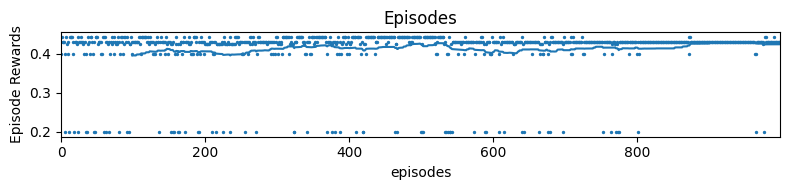

In [153]:
# ver = "Timesteps" 
ver ="Episodes"
if ver == "Timesteps":
    results_plotter.plot_results([f"logs_{ENV_NAME}"], TIME_STEPS, results_plotter.X_TIMESTEPS, "Timesteps")
elif ver == "Episodes":
    results_plotter.plot_results([f"logs_{ENV_NAME}"], TIME_STEPS, results_plotter.X_EPISODES, "Episodes")

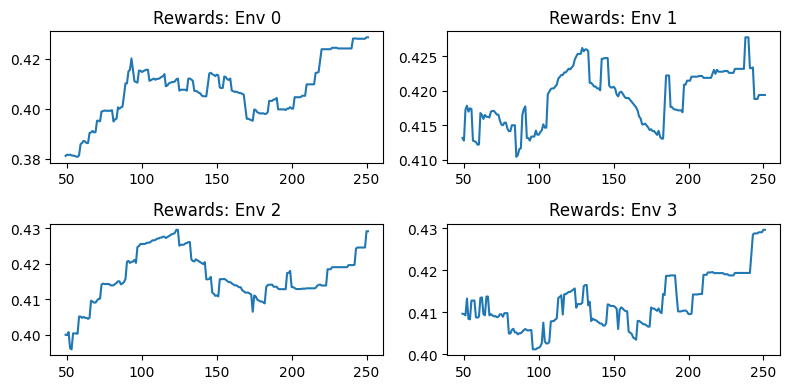

In [148]:
log_files = [os.path.join(f"logs_{ENV_NAME}", f"fol_{i}.monitor.csv") for i in range(n_envs)]

nrows = np.ceil(n_envs/2)
fig = plt.figure(figsize=(8, 2 * nrows))
for i, log_file in enumerate(log_files):
    if os.path.isfile(log_file):
        df_results = pd.read_csv(log_file, skiprows=1)
        plt.subplot(int(nrows), 2, i+1, label=log_file)
        df_results['r'].rolling(window=50).mean().plot(title=f"Rewards: Env {i}")
        plt.tight_layout()
plt.show()

Vemos las acciones que realiza el agente y las recompensas paso a paso:

In [149]:
env.reset()
env.max_turns = 1

acciones = [
    # 'crear_drs_antecedente',
    # 'enmascarar',
    # 'incluir_sustantivo',
    # 'enmascarar',
    # 'crear_drs_consecuente',
    # 'incluir_sustantivo_sin_ref',
    # "mover_derecha",
]

states, list_actions = quick_inspection(model, env, acciones)


Iteración 1

------------------------------------------------------------
Índice: 0
Nivel: 0
Trees are plants
Trees are plants
EMPTY(empty)
------------------------------------------------------------

accion: incluir_sustantivo
Recompensa: 0.4291282051282051

Índice: 1
Nivel: 0
Frase inicial: Trees are plants
Frase procesada: [MASK] are plants
FOL: exists x.TREE(x)
terminated: False, truncated: True
Total reward: 0.4291282051282051


Estos son los valores $q$ del agente:

In [150]:
obs = states[0]
q_values_at_state(model, env, obs)

+----------------------------+---------------------+
|           Acción           |        Valor        |
+----------------------------+---------------------+
|     incluir_sustantivo     | 0.43433648347854614 |
| incluir_sustantivo_sin_ref |  0.4136768579483032 |
|         enmascarar         |  0.3370434641838074 |
|       mover_derecha        |  0.2689920961856842 |
|   crear_drs_antecedente    |  0.2656800150871277 |
|   crear_drs_consecuente    | 0.20161958038806915 |
+----------------------------+---------------------+


Estas son las recompensas del entorno para comparar con los valores $q$:

In [151]:
env.debug = False
acciones_previas = list_actions[:1]
rewards_at_state(env, acciones_previas)

+----------------------------+---------------------+
|           Acción           |      Recompensa     |
+----------------------------+---------------------+
|   crear_drs_antecedente    |  0.6670697674418605 |
| incluir_sustantivo_sin_ref | 0.48257699115044245 |
|         enmascarar         | 0.47840000000000005 |
|     incluir_sustantivo     |  0.4760551724137931 |
|       mover_derecha        |         0.4         |
|   crear_drs_consecuente    |         0.2         |
+----------------------------+---------------------+


from parser.parser_auxiliary_classes import Nodo

env.debug = False
obs, info = env.reset()
env.render()
counter = 0
total_reward = 0
print(f'{env.estado.indice} --- {env.estado.obtener_cadena()} --- {Nodo.llenar_vacios(env.raiz.drs)}')
while True:
    counter += 1
    print('')
    print('-'*60)
    print(f"Iteración {counter}")
    action, _states = model.predict(obs, deterministic=True)
    obs_anterior = obs
    obs, reward, terminated, truncated, info = env.step(action)
    # print(f'Dimensiones diferencia: {np.where(obs != obs_anterior)}')
    total_reward += reward
    print(f"accion := {env.nombre_acciones[action]}")
    print(f'Recompensa: {reward}')
    print(f'Estoy en el nivel {env.estado.nodo.nivel()}')
    env.render()
    print(f'{env.estado.indice} --- {env.estado.nodo.nivel()} --- {env.estado.obtener_cadena()} --- {Nodo.llenar_vacios(env.raiz.drs)}')
    # print(f'Tamaño diferencia: {len(np.where(obs != obs_anterior)[0])}')
    if terminated or truncated:
        break

print(f'Total reward: {total_reward}')

---